# Titanic Survival Prediction

Notebook ini berisi analisis dan pemodelan sederhana untuk memprediksi peluang penumpang Titanic untuk selamat (`Survived`).  
Alur utama notebook:

1. Import dan load dataset
2. Exploratory Data Analysis (EDA)
3. Data cleaning & penanganan missing value
4. Feature engineering
5. Training beberapa model (Naive Bayes, Decision Tree, Random Forest, Logistic Regression) dengan K-Fold cross-validation
6. Membuat submission untuk Kaggle


## 1. Import Library & Load Dataset

Pada bagian ini, saya mengimpor library yang dibutuhkan (pandas, numpy, matplotlib, seaborn) dan memuat data:

- `train.csv` → data latih yang memiliki label `Survived`
- `test.csv` → data uji yang akan diprediksi



In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [6]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Data Understanding

Untuk memahami struktur data, saya melakukan:

- `shape` → melihat jumlah baris dan kolom pada train dan test
- `info()` → tipe data tiap kolom dan apakah ada missing value
- `describe()` → statistik deskriptif untuk fitur numerik
- `isnull().sum()` → jumlah nilai kosong per kolom

Dari sini terlihat kolom seperti `Age`, `Cabin`, dan `Embarked` memiliki missing value dan perlu ditangani pada tahap berikutnya.


In [8]:
test.shape

(418, 11)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

## 3. Exploratory Data Analysis (EDA)

### 3.1 Distribusi Kategori (Univariate)

Saya membuat fungsi `barchart(column)` untuk menampilkan bar chart dari beberapa fitur kategori, seperti:

- `Sex`
- `Pclass`
- `Embarked`
- `SibSp`
- `Parch`

Tujuannya adalah memahami komposisi penumpang berdasarkan jenis kelamin, kelas tiket, pelabuhan keberangkatan, dan hubungan keluarga di kapal.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
train['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [14]:
count_sex = train['Sex'].value_counts()

index_sex = count_sex.index
value_sex = count_sex.values

In [15]:
index_sex

Index(['male', 'female'], dtype='object', name='Sex')

In [16]:
value_sex

array([577, 314], dtype=int64)

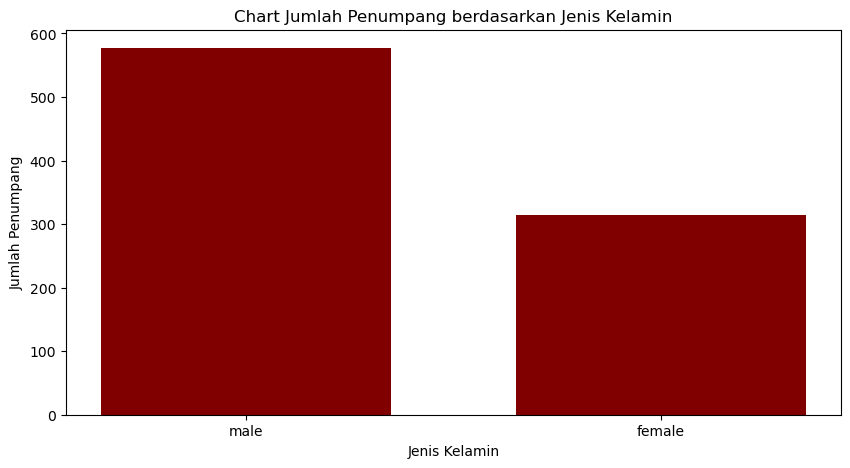

In [17]:
fig = plt.figure(figsize=(10, 5))
plt.bar(index_sex, value_sex, color = 'maroon', width=0.7)

plt.ylabel('Jumlah Penumpang')
plt.xlabel('Jenis Kelamin')
plt.title('Chart Jumlah Penumpang berdasarkan Jenis Kelamin')

plt.show()

In [18]:
def barchart(column) :
    count = train[column].value_counts()

    index = count.index
    value = count.values

    fig = plt.figure(figsize=(10,5))
    plt.bar(index, value, color='maroon', width=0.7)

    plt.show()

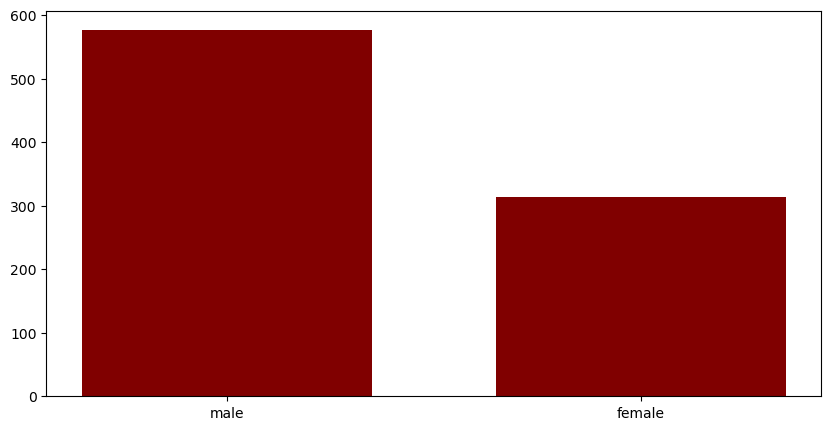

In [19]:
barchart('Sex')

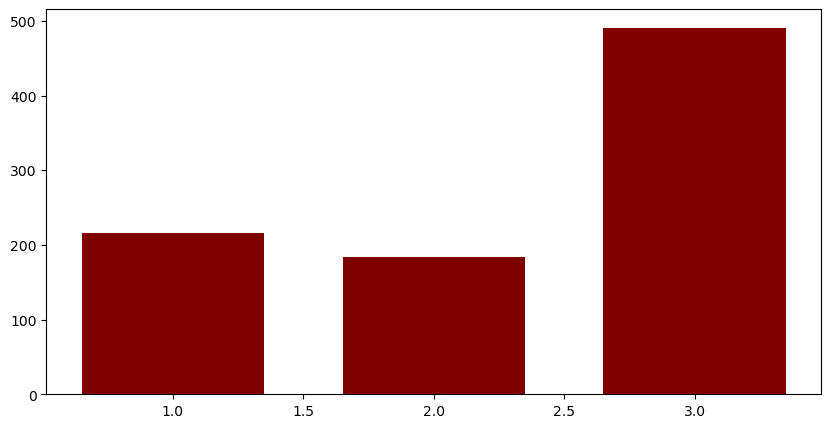

In [20]:
barchart('Pclass')

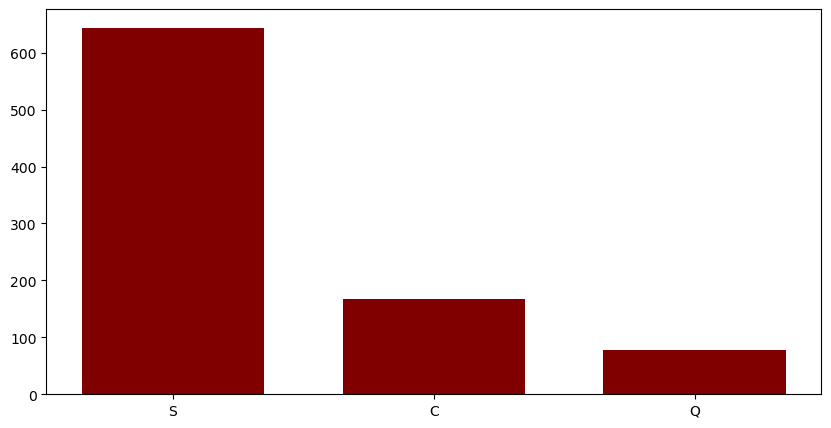

In [21]:
barchart('Embarked')

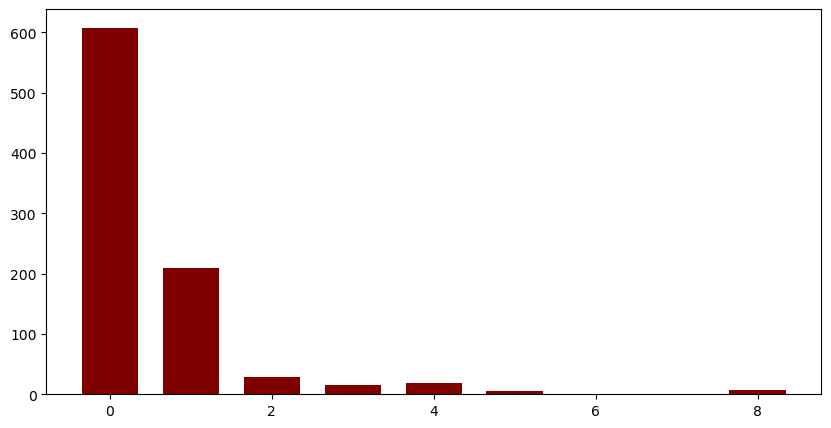

In [22]:
barchart('SibSp')

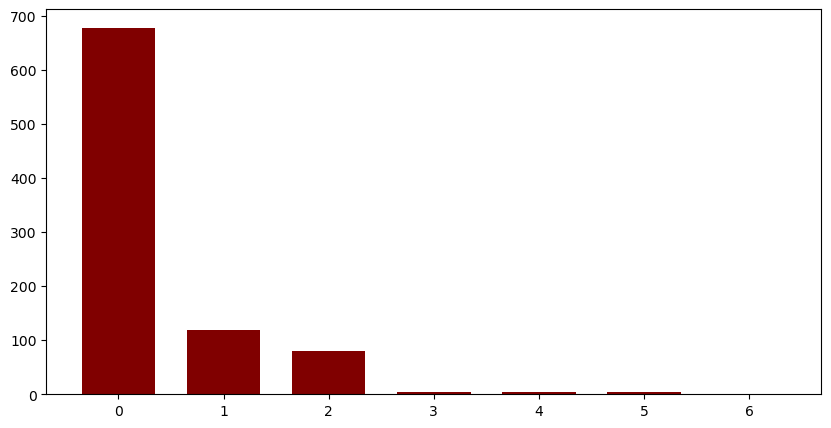

In [23]:
barchart('Parch')

### 3.2 Hubungan Fitur dengan Survived

Fungsi `group_barchart(column)` digunakan untuk melihat hubungan antara fitur tertentu dan label `Survived`.

Contoh yang dianalisis:

- `Sex` vs `Survived` → memperlihatkan bahwa perempuan memiliki peluang selamat lebih tinggi.
- `Pclass` vs `Survived` → penumpang kelas 1 cenderung memiliki tingkat keselamatan lebih baik dibanding kelas 3.

Visualisasi ini membantu membangun intuisi fitur mana yang penting untuk model.


In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
survived = train.groupby(['Survived', 'Sex']).count()['PassengerId'].reset_index()

In [26]:
survived

,Survived,Sex,PassengerId
0,0,female,81
1,0,male,468
2,1,female,233
3,1,male,109


In [27]:
def group_barchart(column) :
    survived = train.groupby(['Survived', column]).count()['PassengerId'].reset_index()

    g = sns.catplot(
        data = survived, kind='bar',
        x ='Survived', y ='PassengerId', hue=column,
        palette = 'dark', height = 6
    )

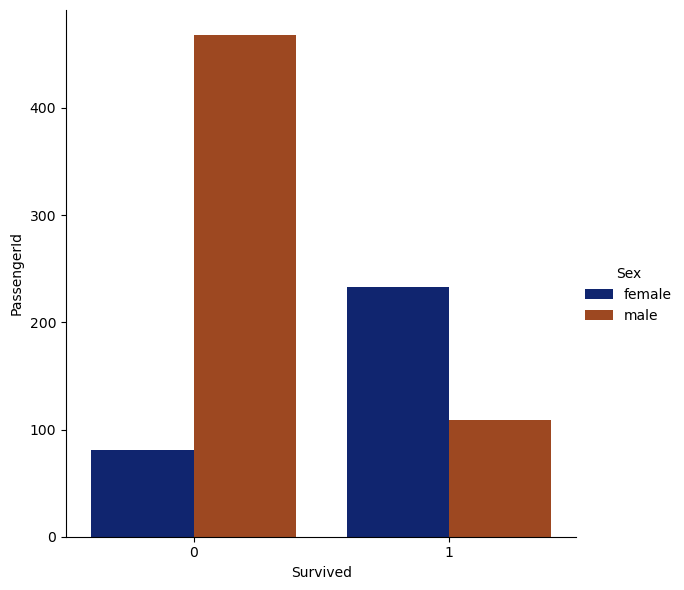

In [28]:
group_barchart('Sex')

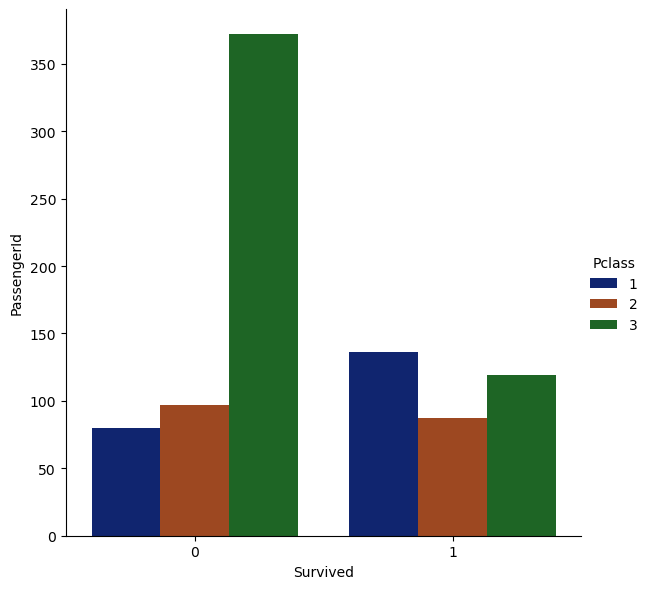

In [29]:
group_barchart('Pclass')

### 3.3 Distribusi Fitur Numerik

Saya juga melihat distribusi:

- `Age` → usia penumpang, terlihat cukup lebar dan tidak simetris.
- `Fare` → harga tiket, cenderung skewed (banyak nilai kecil, sedikit nilai sangat besar).

Informasi ini penting untuk memutuskan cara mengisi missing value (misalnya menggunakan mean/median) dan memahami karakteristik data.


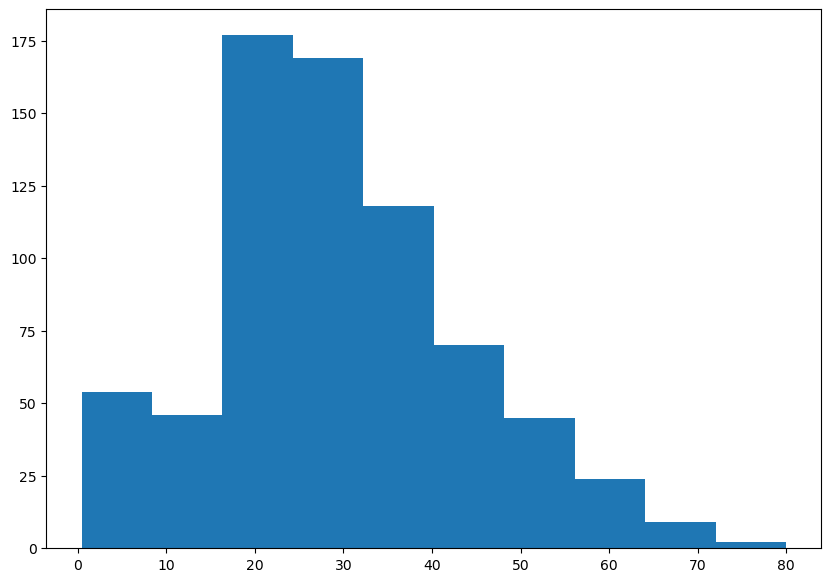

In [30]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(train.Age)

plt.show()

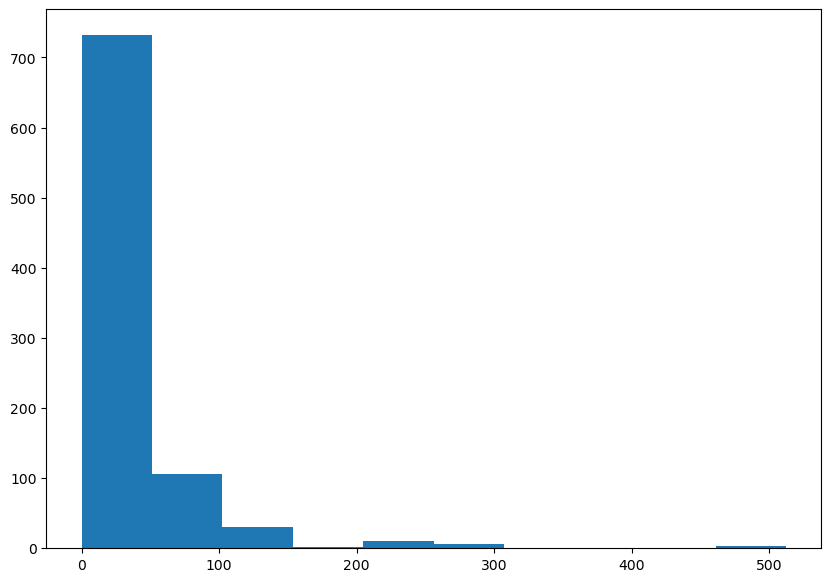

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(train.Fare)

plt.show()

## KDE

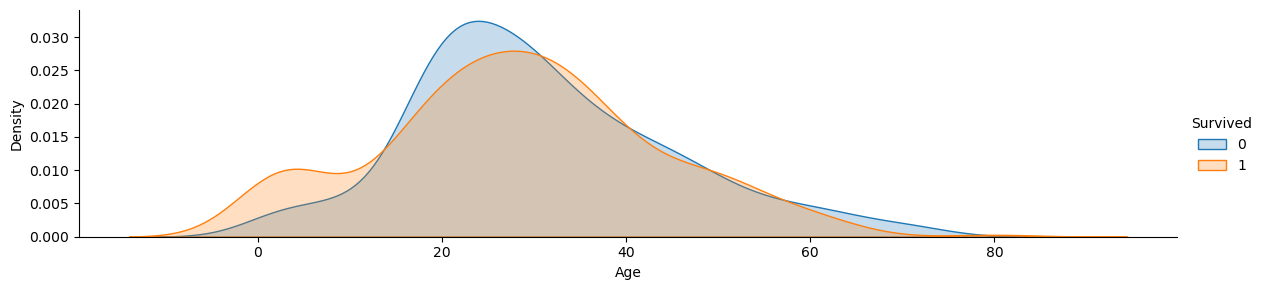

In [32]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', fill=True)
facet.add_legend()
plt.show()

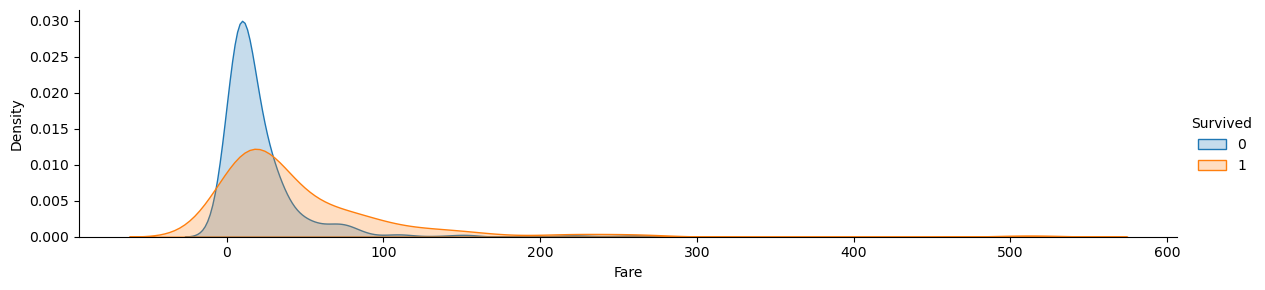

In [33]:
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', fill=True)
facet.add_legend()
plt.show()

# PREPROCESSING DATA

In [30]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [31]:
test.isna().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

## 4. Data Cleaning & Missing Value Handling

Langkah penanganan missing value yang dilakukan:

- **Embarked (train)**  
  - Cek baris yang kosong.
  - Isi menggunakan modus (nilai yang paling sering muncul).

- **Age (train & test)**  
  - Isi menggunakan mean usia masing-masing dataset.

- **Fare (test)**  
  - Isi menggunakan mean harga tiket pada data test.

- **Cabin**  
  - Kolom ini memiliki terlalu banyak missing value dan informasinya tidak sederhana untuk diolah, sehingga di-drop dari train dan test.

Setelah proses ini, dicek ulang dengan `isnull().sum()` untuk memastikan tidak ada lagi missing value yang tersisa.


### Missig Value Embarked

In [32]:
# mengisi missing value feature Embarked
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [33]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [34]:
modus_embarked = train['Embarked'].mode()[0]
modus_embarked

'S'

In [35]:
train['Embarked'] = train['Embarked'].fillna(modus_embarked)

In [36]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [37]:
train[train['Embarked'].index==61]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S


### Missing Value Age

In [38]:
mean_age = train['Age'].mean()
mean_age

29.69911764705882

In [39]:
train['Age'] = train['Age'].fillna(mean_age)

In [40]:
mean_age_test = test['Age'].mean()
mean_age_test

30.272590361445783

In [41]:
test['Age'] = test['Age'].fillna(mean_age_test)

### Missing Value Data Fare

In [42]:
mean_fare_test = test['Fare'].mean()

test['Fare'] = test['Fare'].fillna(mean_fare_test)

In [43]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [44]:
train.isnull().sum()
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## 5. Feature Engineering & Encoding

Beberapa fitur kategori diubah menjadi bentuk numerik agar bisa digunakan oleh model Machine Learning:

- **Sex**  
  - Di-mapping menjadi `Male → 1`, `Female → 0`.

- **Embarked**  
  - Diubah menjadi beberapa kolom dummy (`Embarked_C`, `Embarked_Q`, `Embarked_S`) dengan `pd.get_dummies`.
  - Kolom asli `Embarked` kemudian di-drop.

- **Title (gelar)**  
  - Diekstrak dari kolom `Name` menggunakan regex (misalnya `Mr`, `Mrs`, `Miss`, `Master`, dll).
  - Gelar-gelar langka dikelompokkan ke satu kategori dan di-mapping ke angka.
  - Fitur `title` ini membantu menangkap informasi sosial/umur yang tidak langsung terlihat dari kolom lain.

Kolom identitas yang tidak informatif untuk prediksi (`PassengerId`, `Name`, `Ticket`) di-drop dari train dan test.


In [45]:
sex_mapping = {"male" : 1, "female" : 0}

train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

In [46]:
train['Sex'].unique()

array([1, 0], dtype=int64)

In [47]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,S


### Convert data Embarked

In [48]:
embarked = train[['Embarked']]
dummies_train = pd.get_dummies(embarked, dtype=int)
dummies_train.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [49]:
train = pd.merge(train.reset_index(), dummies_train.reset_index())
train.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,0,0,1
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,1,0,0
2,2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,0,0,1
4,4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,0,0,1


In [50]:
train = train.drop(['index', 'Embarked'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,1


In [51]:
embarked = test[['Embarked']]
dummies_test = pd.get_dummies(embarked, dtype=int)
test = pd.merge(test.reset_index(), dummies_test.reset_index())
test = test.drop(['index', 'Embarked'], axis=1)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,1,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,0,1


## Extract Data Title dan Convert Title

In [52]:
train['title'] = train['Name'].str.extract( ' ([A-Za-z]+)\.', expand = False)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ACER\AppData\Local\Temp\ipykernel_15020\2343356743.py:1: SyntaxWarning: invalid escape sequence '\.'
  train['title'] = train['Name'].str.extract( ' ([A-Za-z]+)\.', expand = False)


In [53]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,0,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,1,Mr


In [54]:
title_mapping = {'Mr':0,
                 'Miss' : 1,
                 'Mrs' : 2,
                 'Master' : 3, 'Dr' : 3, 'Rev': 3, 'Col': 3, 'Major': 3, 'Countess': 3,
                 'Ms': 3, 'Lady': 3, 'Jonkheer': 3, 'Don': 3, 'Dona': 3, "Mme": 3, "Capt": 3, "Sir": 3, "Mlle" :3 }

train['title'] = train['title'].map(title_mapping)

In [55]:
test['title'] = test['Name'].str.extract( ' ([A-Za-z]+)\.', expand = False)

test['title'] = test['title'].map(title_mapping)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ACER\AppData\Local\Temp\ipykernel_15020\2504587569.py:1: SyntaxWarning: invalid escape sequence '\.'
  test['title'] = test['Name'].str.extract( ' ([A-Za-z]+)\.', expand = False)


In [56]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,0,1,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,1,0


In [57]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,0,1,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,1,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,0,1,2


## Select Column

In [58]:
train.shape, test.shape

((891, 14), (418, 13))

In [59]:
train = train.drop(["PassengerId", "Name", "Ticket"], axis=1)
test_id = test[['PassengerId']]

test = test.drop(["PassengerId", "Name", "Ticket"], axis=1)

In [60]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,title
0,3,1,34.5,0,0,7.8292,0,1,0,0
1,3,0,47.0,1,0,7.0000,0,0,1,2
2,2,1,62.0,0,0,9.6875,0,1,0,0
3,3,1,27.0,0,0,8.6625,0,0,1,0
4,3,0,22.0,1,1,12.2875,0,0,1,2


## 6. Menyiapkan Data untuk Modeling

- `x_train` berisi semua fitur input (tanpa kolom `Survived`).
- `y_train` berisi label target (`Survived` = 0 atau 1).

Data inilah yang akan digunakan pada proses training dan cross-validation.


In [62]:
x_train = train.drop("Survived", axis=1)
y_train = train["Survived"]

## 7. Modeling & K-Fold Cross-Validation

Untuk mengevaluasi model, saya menggunakan:

- **KFold Cross-Validation (5-fold)** dengan `shuffle=True`
- Metrik evaluasi: **accuracy**

Beberapa algoritma yang dicoba:

1. `GaussianNB` (Naive Bayes)
2. `DecisionTreeClassifier`
3. `RandomForestClassifier`
4. `LogisticRegression` (dengan peringatan konvergensi karena jumlah iterasi default belum cukup)

Setiap blok kode berisi:

- Definisi model `clf = ...`
- `cross_val_score()` untuk mendapatkan skor di setiap fold
- `score.mean()` sebagai rata-rata akurasi.

Dari hasilnya, model seperti Random Forest dan Logistic Regression memberikan akurasi rata-rata sekitar **0.80–0.81**, sedikit lebih baik dibanding Naive Bayes dan Decision Tree.


In [63]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.78212291 0.78651685 0.78089888 0.8258427  0.82022472]


In [64]:
score.mean()

0.7991212102190698

In [65]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.73743017 0.78651685 0.79775281 0.7752809  0.78651685]


In [66]:
score.mean()

0.7766995166656205

In [67]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = RandomForestClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83240223 0.81460674 0.83707865 0.78651685 0.78089888]


In [68]:
score.mean()

0.8103006716464755

In [69]:
from sklearn.linear_model import LogisticRegression
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = LogisticRegression(max_iter=1000)
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, scoring=scoring)
print(score)
print(score.mean())

[0.7877095  0.79775281 0.82022472 0.83146067 0.83146067]
0.8137216747222397


In [70]:
score.mean()

0.8137216747222397

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = GradientBoostingClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83798883 0.81460674 0.84831461 0.83707865 0.80337079]


In [72]:
score.mean()

0.8282719226664993

In [73]:
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [74]:
prediction = clf.predict(test)

## 8. Training Model Akhir & Membuat Submission

Pada tahap akhir:

1. Model terbaik dilatih ulang menggunakan seluruh data train.
2. Model digunakan untuk memprediksi label `Survived` pada data test.
3. Dibuat file `Submission.csv` yang berisi:
   - `PassengerId`
   - `Survived` (hasil prediksi)

File ini siap di-upload ke Kaggle untuk melihat skor di leaderboard.


In [75]:
df_test = pd.read_csv("dataset/test.csv")
submission = pd.DataFrame({
        "PassengerId":df_test["PassengerId"],
        "Survived" : prediction
})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [76]:
submission.to_csv("Submission.csv", index = False)

In [77]:
test['survived'] = submission['Survived']
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,title,survived
0,3,1,34.5,0,0,7.8292,0,1,0,0,0
1,3,0,47.0,1,0,7.0000,0,0,1,2,0
2,2,1,62.0,0,0,9.6875,0,1,0,0,0
3,3,1,27.0,0,0,8.6625,0,0,1,0,0
4,3,0,22.0,1,1,12.2875,0,0,1,2,1
